In [24]:
import math
import random
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import spacy
import yake
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from typing import List

from tqdm import tqdm


nlp = spacy.load("en_core_web_sm")
kw_extractor = yake.KeywordExtractor(n=1,
                                     dedupLim=0.9,
                                     top=10,
                                     features=None)


class BM25:
    def __init__(self, corpus: List[List[str]], k1=1.5, b=0.95):
        self.corpus = corpus
        self.k1 = k1
        self.b = b
        self.documents_number = len(corpus)
        self.avgdl = sum(len(document) for document in corpus) / self.documents_number
        self.df = self._calculate_df()
        self.idf = self._calculate_idf()

    def _calculate_df(self):
        df = {}
        for document in self.corpus:
            for word in set(document):
                df[word] = df.get(word, 0) + 1
        return df

    def _calculate_idf(self):
        idf = {}
        for word, freq in self.df.items():
            idf[word] = math.log((self.documents_number - freq + 0.5) / (freq + 0.5) + 1)
        return idf

    def _score(self, document, query):
        score = 0.0
        for word in query:
            if word in self.df:
                idf = self.idf[word]
                term_freq = document.count(word)
                score += (idf * term_freq * (self.k1 + 1)) / (
                        term_freq + self.k1 * (1 - self.b + self.b * len(document) / self.avgdl))
        return score

    def get_scores(self, query):
        scores = []
        for index, document in enumerate(self.corpus):
            score = self._score(document, query)
            scores.append((index, score))
        return scores

In [25]:
from transformers import BertTokenizer
import torch
class MixedLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, pos_weight=None, mix_ratio=0.5):
        super(MixedLoss, self).__init__()
        self.focal_loss = FocalLoss(weight=weight, gamma=gamma, reduction="mean").to(device)
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        self.mix_ratio = mix_ratio

    def forward(self, inputs, targets):
        loss_focal = self.focal_loss(inputs, targets)
        loss_bce = self.bce_loss(inputs, targets)
        return (self.mix_ratio * loss_focal) + ((1 - self.mix_ratio) * loss_bce)
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2., reduction='none'):
        super(FocalLoss, self).__init__()
        self.weight = weight.to(device)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        BCE_loss = BCE_loss.to(device)
        pt = torch.exp(-BCE_loss)
        F_loss = self.weight * ((1 - pt) ** self.gamma) * BCE_loss

        if self.reduction == 'sum':
            return torch.sum(F_loss)
        elif self.reduction == 'mean':
            return torch.mean(F_loss)
        else:
            return F_loss
def classify(question):
    load_model_name = "./model_state_dict_all_data_1.pth"
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BERTMultiLabelBinaryClassification_FactorLoss(num_labels=6, gamma=2.5,
                                                          mix_ratio=0.3, label_weight=[0, 0, 0, 0, 0, 0])
    model.load_state_dict(torch.load(load_model_name, map_location=device))

    sentence_encodings = tokenizer(question, truncation=True, padding=True, max_length=128)
    sentence_seq = torch.tensor(sentence_encodings['input_ids'])
    sentence_mask = torch.tensor(sentence_encodings['attention_mask'])
    model.eval()
    with torch.no_grad():
        model.cpu()
        inputs = {
            'input_ids': sentence_seq.unsqueeze(0),
            'attention_mask': sentence_mask.unsqueeze(0)
        }
        outputs = model(**inputs)
        logits = torch.sigmoid(outputs).detach().cpu().numpy()

    pred_labels = (logits > 0.5).astype(int)
    return pred_labels[0]

In [27]:
from transformers import BertForSequenceClassification
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BERTMultiLabelBinaryClassification_FactorLoss(torch.nn.Module):
    def __init__(self, num_labels, label_weight, gamma=2.0, mix_ratio=0.5):
        super(BERTMultiLabelBinaryClassification_FactorLoss, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
        self.label_weight = torch.tensor(label_weight)
        self.gamma = gamma
        self.mixed_loss = MixedLoss(weight=self.label_weight, gamma=self.gamma, pos_weight=self.label_weight,
                                    mix_ratio=mix_ratio).to(device)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        if labels is not None:
            loss = self.mixed_loss(logits.view(-1, self.bert.config.num_labels),
                                   labels.view(-1, self.bert.config.num_labels))
            return loss
        else:
            return logits


class BERTMultiLabelBinaryClassification(torch.nn.Module):
    def __init__(self, num_labels, label_weight):
        super(BERTMultiLabelBinaryClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
        self.label_weight = label_weight

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        if labels is not None:
            pos_weight = torch.tensor(self.label_weight)
            pos_weight.to(device)
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            loss_fct.to(device)
            loss = loss_fct(logits.view(-1, self.bert.config.num_labels), labels.view(-1, self.bert.config.num_labels))
            return loss
        else:
            return logits


In [28]:
def search_bm25(query: str, bm25, top_k):
    global df
    tokenized_query = query.split()
    scores = bm25.get_scores(tokenized_query)
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_k]
    result = {}
    for doc_index, score in sorted_scores:
        pmid = df.iloc[doc_index]['PMID']
        result[pmid] = score
    return list(result.keys())

In [29]:
def search(query: str, df, keywords, bm25, top_k):
    tokenized_query = query.split()
    tokenized_query.extend(keywords)
    scores = bm25.get_scores(tokenized_query)
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_k]
    result = {}
    for doc_index, score in sorted_scores:
        pmid = df.iloc[doc_index]['PMID']
        result[pmid] = score
    return list(result.keys())

In [30]:
def extract_keywords(text):
    keywords = kw_extractor.extract_keywords(text)
    keywords_set = {word for word, _ in keywords}
    return list(set(keywords_set))


def query_pre_process(query):
    proper_nouns = extract_keywords(query)
    proper_nouns = [word for word in proper_nouns if word.lower() not in ENGLISH_STOP_WORDS] * 1
    return proper_nouns

In [31]:
df = pd.read_csv('./PubmedDataSet.csv')
texts = df['Abstract'].tolist()
tokenized_texts = [doc.split() for doc in texts]
bm25_abstract = BM25(tokenized_texts)
# 准备测试数据
df_test = pd.read_csv('./evaluation.csv')
test = []

for index, row in df_test.iterrows():
    small_list = [row["Question"], row["PMID"]]
    test.append(small_list)
random.seed(42)
random.shuffle(test)
test = test[:100]
    


In [12]:
# 原始bm25 Recall
t = 0
for query, pmid in tqdm(test):
    top_pmids = search_bm25(query, bm25_abstract, 3)
    if pmid in top_pmids:
        t += 1
print(f'recall of bm25 {t / len(test)}')

100%|█████████████████████████████████████████| 300/300 [09:48<00:00,  1.96s/it]

recall of bm25 0.7633333333333333


In [33]:
# 原始bm25 MRR

Q = len(test)
MRR = 0
for query, pmid in tqdm(test):
    top_pmids = search_bm25(query, bm25_abstract, 3)
    try:
        rank = top_pmids.index(pmid) + 1
        MRR += 1 / rank
    except:
        rank = 0
MRR = MRR / Q
print(f'MRR is {MRR}')

100%|█████████████████████████████████████████| 100/100 [03:21<00:00,  2.02s/it]

MRR is 0.735


  0%|                                                   | 0/100 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|▍                                          | 1/100 [00:05<08:28,  5.14s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▊                                          | 2/100 [00:14<12:27,  7.63s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 22%|█████████▏                                | 22/100 [01:40<05:46,  4.44s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 23%|█████████▋                                | 23/100 [01:44<05:38,  4.39s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 24%|██████████                                | 24/100 [01:49<05:31,  4.36s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 44%|██████████████████▍                       | 44/100 [03:13<04:20,  4.66s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 45%|██████████████████▉                       | 45/100 [03:18<04:29,  4.91s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 46%|███████████████████▎                      | 46/100 [03:21<03:55,  4.36s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 66%|███████████████████████████▋              | 66/100 [04:49<02:20,  4.14s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 67%|████████████████████████████▏             | 67/100 [04:54<02:26,  4.43s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 68%|████████████████████████████▌             | 68/100 [04:58<02:23,  4.48s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 88%|████████████████████████████████████▉     | 88/100 [06:09<00:51,  4.27s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 89%|█████████████████████████████████████▍    | 89/100 [06:12<00:43,  3.93s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 90%|█████████████████████████████████████▊    | 90/100 [06:16<00:39,  3.95s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

recall of bm25 on each type{'Confirmation Questions': 0.8888888888888888, 'Factoid-type Questions': 0.7037037037037037, 'List-type Questions': 0.8181818181818182, 'Causal Questions': 0.8666666666666667, 'Hypothetical Questions': 0.7407407407407407, 'Complex Questions': 0.813953488372093}


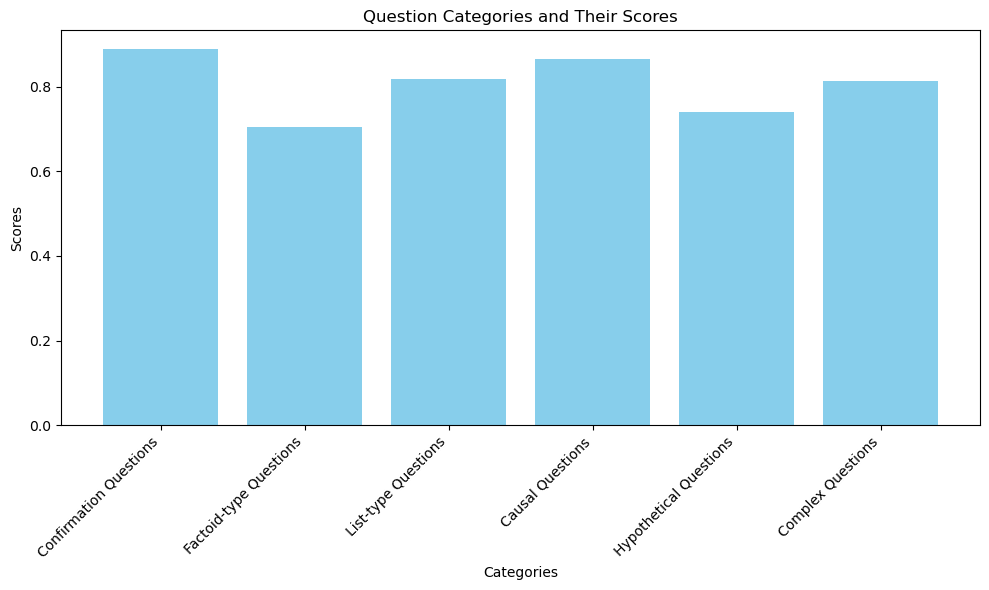

In [32]:
# 原始bm25针对不同type Recall
TYPE = ['Confirmation Questions', 'Factoid-type Questions', 'List-type Questions', 'Causal Questions',
        'Hypothetical Questions', 'Complex Questions']
t = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
t_base = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
for query, pmid in tqdm(test):
    type = classify(query)
    valid_types = [TYPE[i] for i, val in enumerate(type) if val == 1]
    top_pmids = search_bm25(query, bm25_abstract, 3)
    for typ in valid_types:
        t_base[typ] += 1
    if pmid in top_pmids:
        for typ in valid_types:
            t[typ] += 1
for key, val in t.items():
    t[key] = t[key] / t_base[key]
print(f'recall of bm25 on each type{t}')


import matplotlib.pyplot as plt
categories = list(t.keys())
values = list(t.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')


plt.title('Question Categories and Their Scores')
plt.xlabel('Categories')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')  


plt.tight_layout()  
plt.show()

  0%|                                                   | 0/100 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|▍                                          | 1/100 [00:05<08:59,  5.45s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▊                                          | 2/100 [00:13<11:39,  7.13s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 22%|█████████▏                                | 22/100 [01:32<05:39,  4.35s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 23%|█████████▋                                | 23/100 [01:36<05:33,  4.33s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 24%|██████████                                | 24/100 [01:40<05:15,  4.15s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 44%|██████████████████▍                       | 44/100 [02:59<04:05,  4.39s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 45%|██████████████████▉                       | 45/100 [03:04<04:09,  4.53s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 46%|███████████████████▎                      | 46/100 [03:07<03:40,  4.08s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 66%|███████████████████████████▋              | 66/100 [04:25<02:05,  3.70s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 67%|████████████████████████████▏             | 67/100 [04:29<02:04,  3.76s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 68%|████████████████████████████▌             | 68/100 [04:32<02:00,  3.77s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 88%|████████████████████████████████████▉     | 88/100 [05:42<00:46,  3.88s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 89%|█████████████████████████████████████▍    | 89/100 [05:45<00:39,  3.57s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 90%|█████████████████████████████████████▊    | 90/100 [05:48<00:36,  3.64s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

RMM of bm25 on each type{'Confirmation Questions': 0.8888888888888888, 'Factoid-type Questions': 0.6666666666666666, 'List-type Questions': 0.7727272727272727, 'Causal Questions': 0.8666666666666667, 'Hypothetical Questions': 0.7222222222222222, 'Complex Questions': 0.8023255813953488}


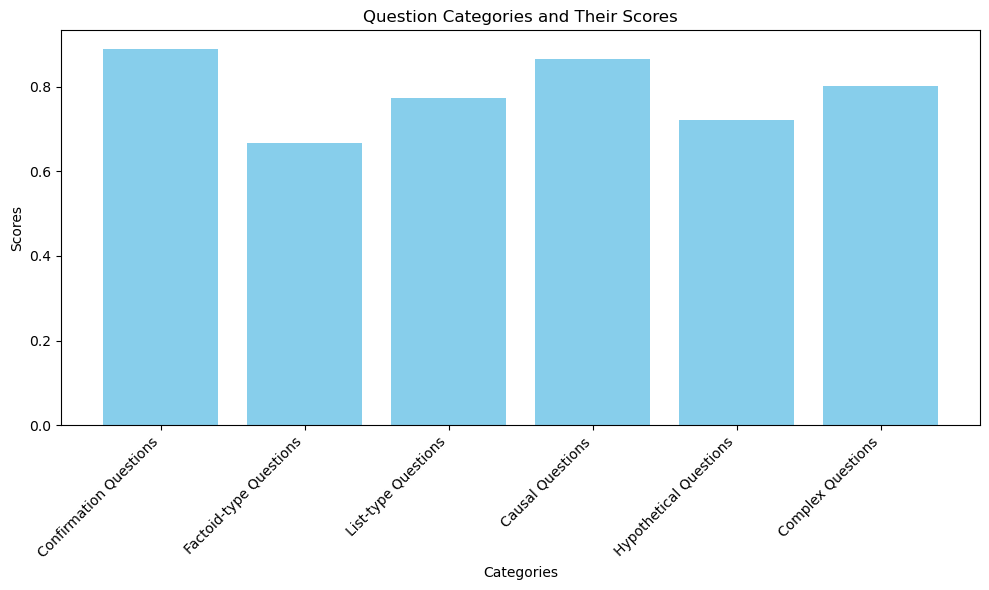

In [35]:
t = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
t_count = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
for query, pmid in tqdm(test):
    type = classify(query)
    valid_types = [TYPE[i] for i, val in enumerate(type) if val == 1]
    top_pmids = search_bm25(query, bm25_abstract, 3)
    for typ in valid_types:
        t_count[typ] += 1
    if pmid in top_pmids:
        rank = top_pmids.index(pmid) + 1
        for typ in valid_types:
            t[typ] += 1 / rank

for key, val in t.items():
    t[key] = t[key] / t_count[key]
print(f'RMM of bm25 on each type{t}')


import matplotlib.pyplot as plt
categories = list(t.keys())
values = list(t.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')


plt.title('Question Categories and Their Scores')
plt.xlabel('Categories')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')  


plt.tight_layout()  
plt.show()

In [36]:
import random

import pandas as pd
import spacy
import yake
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from typing import List

from tqdm import tqdm



nlp = spacy.load("en_core_web_sm")
kw_extractor = yake.KeywordExtractor(n=1,
                                     dedupLim=0.9,
                                     top=10,
                                     features=None)

In [37]:
df = pd.read_csv('./PubmedDataSet.csv')
texts = df['Abstract'].tolist()
tokenized_texts = [doc.split() for doc in texts]
bm25_abstract = BM25(tokenized_texts)

In [38]:
df2 = pd.read_csv('./splitted_pubmed_data_NLTK.csv')
df_test = pd.read_csv('./evaluation.csv')
test = []
for index, row in df_test.iterrows():
    small_list = [row["Question"], row["PMID"]]
    test.append(small_list)
random.seed(42)
random.shuffle(test)
test = test[:100]

In [39]:
t = 0
for query, pmid in tqdm(test):
    keywords = query_pre_process(query)
    result_pmids_scores = search(query, df, keywords, bm25_abstract, top_k=30)
    mask = df2['PMID'].isin(result_pmids_scores)
    df_t = df2[mask]
    texts = df_t['chunk_text'].tolist()
    tokenized_texts = [doc.split() for doc in texts]

    bm25_chunk = BM25(tokenized_texts)
    result_pmids_scores = search(query, df_t, keywords, bm25_chunk, top_k=3)
    if pmid in result_pmids_scores:
        t += 1
print(f'recall of bm25 {t / len(test)}')

100%|█████████████████████████████████████████| 100/100 [04:48<00:00,  2.89s/it]

recall of bm25 0.77


In [40]:
Q = len(test)
MRR = 0
for query, pmid in tqdm(test):
    keywords = query_pre_process(query)
    result_pmids_scores = search(query, df, keywords, bm25_abstract, top_k=100)
    mask = df2['PMID'].isin(result_pmids_scores)
    df_t = df2[mask]
    texts = df_t['chunk_text'].tolist()
    tokenized_texts = [doc.split() for doc in texts] 

    bm25_chunk = BM25(tokenized_texts)
    result_pmids_scores = search(query, df_t, keywords, bm25_chunk, top_k=3)

    try:
        rank = result_pmids_scores.index(pmid) + 1
        MRR += 1 / rank
    except:
        rank = 0
MRR = MRR / Q
print(f'MRR is {MRR}')

100%|█████████████████████████████████████████| 100/100 [04:49<00:00,  2.89s/it]

MRR is 0.74


  0%|                                                   | 0/100 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|▍                                          | 1/100 [00:07<12:29,  7.57s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▊                                          | 2/100 [00:17<14:12,  8.70s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 22%|█████████▏                                | 22/100 [02:02<07:29,  5.76s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 23%|█████████▋                                | 23/100 [02:09<07:35,  5.92s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 24%|██████████                                | 24/100 [02:15<07:33,  5.96s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 44%|██████████████████▍                       | 44/100 [04:00<05:31,  5.91s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 45%|██████████████████▉                       | 45/100 [04:07<05:33,  6.07s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 46%|███████████████████▎                      | 46/100 [04:10<04:39,  5.18s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 66%|███████████████████████████▋              | 66/100 [06:00<03:07,  5.52s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 67%|████████████████████████████▏             | 67/100 [06:05<02:57,  5.38s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 68%|████████████████████████████▌             | 68/100 [06:10<02:51,  5.37s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 88%|████████████████████████████████████▉     | 88/100 [07:49<01:06,  5.55s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 89%|█████████████████████████████████████▍    | 89/100 [07:53<00:55,  5.07s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 90%|█████████████████████████████████████▊    | 90/100 [07:57<00:49,  4.96s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

recall of bm25 on each type{'Confirmation Questions': 0.8888888888888888, 'Factoid-type Questions': 0.6913580246913581, 'List-type Questions': 0.7727272727272727, 'Causal Questions': 0.8666666666666667, 'Hypothetical Questions': 0.6790123456790125, 'Complex Questions': 0.7790697674418605}


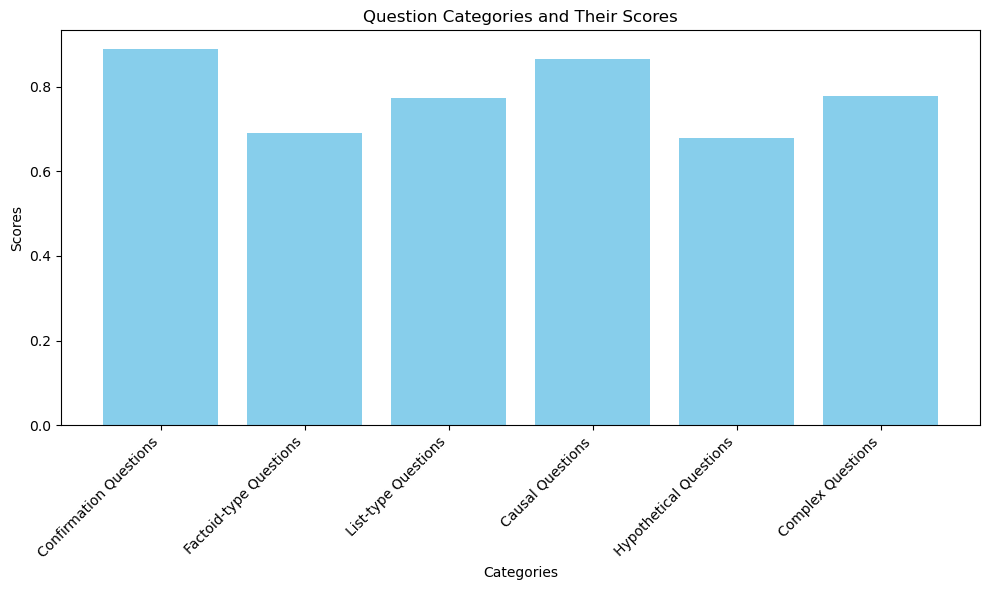

In [41]:
TYPE = ['Confirmation Questions', 'Factoid-type Questions', 'List-type Questions', 'Causal Questions',
        'Hypothetical Questions', 'Complex Questions']
t = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
t_base = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
for query, pmid in tqdm(test):
    type = classify(query)
    valid_types = [TYPE[i] for i, val in enumerate(type) if val == 1]
    keywords = query_pre_process(query)
    result_pmids_scores = search(query, df, keywords, bm25_abstract, top_k=60)
    mask = df2['PMID'].isin(result_pmids_scores)
    df_t = df2[mask]
    texts = df_t['chunk_text'].tolist()
    tokenized_texts = [doc.split() for doc in texts]

    bm25_chunk = BM25(tokenized_texts)
    top_pmids = search(query, df_t, keywords, bm25_chunk, top_k=3)

    for typ in valid_types:
        t_base[typ] += 1
    if pmid in top_pmids:
        rank = top_pmids.index(pmid) + 1
        for typ in valid_types:
            t[typ] += 1 / rank

for key, val in t.items():
    if t_base[key] != 0:
        t[key] = t[key] / t_base[key]
print(f'recall of bm25 on each type{t}')
import matplotlib.pyplot as plt
categories = list(t.keys())
values = list(t.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')

plt.title('Question Categories and Their Scores')
plt.xlabel('Categories')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')  

plt.tight_layout()  
plt.show()

  0%|                                                   | 0/100 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|▍                                          | 1/100 [00:04<08:09,  4.94s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▊                                          | 2/100 [00:14<12:27,  7.62s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 22%|█████████▏                                | 22/100 [01:55<07:06,  5.46s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 23%|█████████▋                                | 23/100 [02:01<07:05,  5.53s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 24%|██████████                                | 24/100 [02:06<06:51,  5.41s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 44%|██████████████████▍                       | 44/100 [03:44<04:55,  5.28s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 45%|██████████████████▉                       | 45/100 [03:50<05:01,  5.48s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 46%|███████████████████▎                      | 46/100 [03:53<04:22,  4.86s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 66%|███████████████████████████▋              | 66/100 [05:33<02:47,  4.93s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 67%|████████████████████████████▏             | 67/100 [05:38<02:42,  4.92s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 68%|████████████████████████████▌             | 68/100 [05:43<02:35,  4.86s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

 88%|████████████████████████████████████▉     | 88/100 [07:08<00:57,  4.81s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 89%|█████████████████████████████████████▍    | 89/100 [07:12<00:48,  4.43s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 90%|█████████████████████████████████████▊    | 90/100 [07:17<00:45,  4.59s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.w

RMM of bm25 on each type{'Confirmation Questions': 0.8888888888888888, 'Factoid-type Questions': 0.7222222222222222, 'List-type Questions': 0.8181818181818182, 'Causal Questions': 0.8666666666666667, 'Hypothetical Questions': 0.7407407407407407, 'Complex Questions': 0.813953488372093}


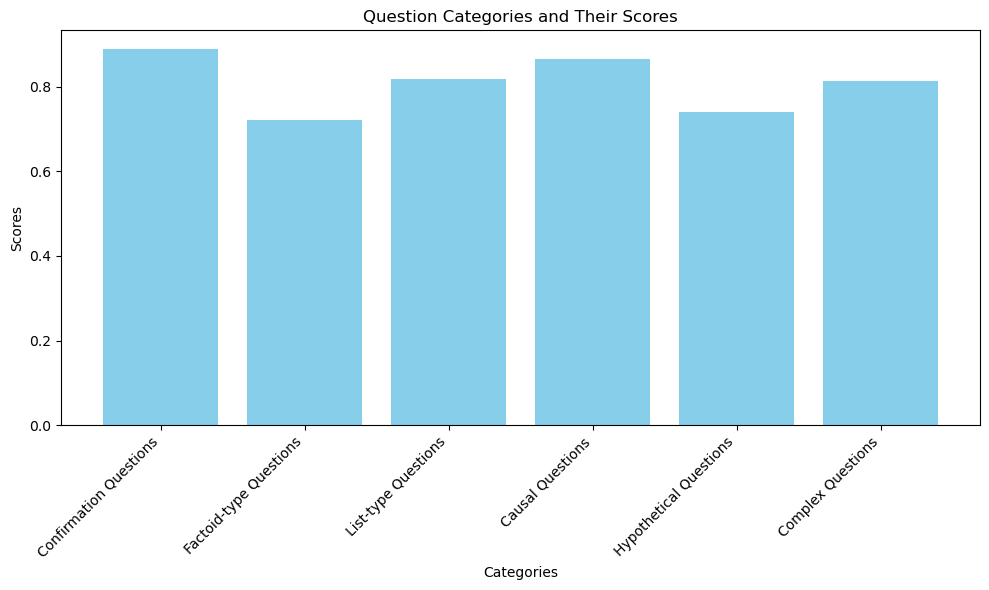

In [42]:
t = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
t_count = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
for query, pmid in tqdm(test):
    type = classify(query)
    valid_types = [TYPE[i] for i, val in enumerate(type) if val == 1]
    keywords = query_pre_process(query)
    result_pmids_scores = search(query, df, keywords, bm25_abstract, top_k=30)
    mask = df2['PMID'].isin(result_pmids_scores)
    df_t = df2[mask]
    texts = df_t['chunk_text'].tolist()
    tokenized_texts = [doc.split() for doc in texts]
    bm25_chunk = BM25(tokenized_texts)
    top_pmids = search(query, df_t, keywords, bm25_chunk, top_k=3)

    for typ in valid_types:
        t_count[typ] += 1

    if pmid in top_pmids:
        for typ in valid_types:
            t[typ] += 1 / rank

for key, val in t.items():
    t[key] = t[key] / t_count[key]
print(f'RMM of bm25 on each type{t}')


import matplotlib.pyplot as plt
categories = list(t.keys())
values = list(t.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')


plt.title('Question Categories and Their Scores')
plt.xlabel('Categories')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')  


plt.tight_layout()  
plt.show()